In [1]:
%run init_notebookspace.py
from settings import *

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\macro_rbc\data


## Table of Content
* [Introduction](#chapter0)
* [Make RBC Model](#chapter3)
    * [Model Equations](#section_3_1)
    * [Find Steady State, Solve the Model](#section_3_2)
    * [Check Blanchard Kahn Conditions](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [A Simple Model](#section_4_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_1)
        * [Forecasting](#subsection_4_2)
    * [A Noisy Model](#section_4_2)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_3)
        * [Forecasting](#subsection_4_4)
    * [Adding Variables](#section_4_3)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_5)
        * [Forecasting](#subsection_4_6)
    * [Final Model](#section_4_4)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_7)
        * [Forecasting](#subsection_4_8)
    * [Impulse response](#section_4_5)
        * [New Steady State](#subsection_4_9)

## Introduction <a class="anchor" id="chapter0"></a>

In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
from gEconpy.shared.utilities import eq_to_ss
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']
maxiter = 15

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()
    pass

In [4]:
# load data
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# drop csv index
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

# time format index
train['TIME'] = time_format(train.TIME)
test['TIME'] = time_format(test.TIME)

# set index - get's lost with csv
train.set_index('TIME', inplace=True)
test.set_index('TIME', inplace=True)

# asign correct time freq
train = train.asfreq('QS')
test = test.asfreq('QS')

glob_cols = list(train.columns)
test_size = len(test)

# Capital Adjustment cost Model <a class="anchor" id="chapter3"></a>

In [5]:
# rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc.gnc'))
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_capadj.gnc'))

Model Building Complete.
Found:
	11 equations
	11 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 4 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_3_1"></a>

In [6]:
for equation in rbc.system_equations:
    display(equation)

-Q_t + lambda_t/q_t

-C_t - I_t + K_t-1*r_t + L_t*w_t

-1*phi*(-delta + I_t/K_t-1)**2*K_t-1/2 + I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

-lambda_t - q_t*(phi*(-delta + I_t/K_t-1) - 1)

beta*(lambda_t+1*r_t+1 - q_t+1*(delta - phi*I_t+1*(-delta + I_t+1/K_t)/K_t + phi*(-delta + I_t+1/K_t)**2/2 - 1)) - q_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_3_2"></a>

In [17]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.831805550351403e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [18]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Q_ss               1.000
Y_ss               3.073
lambda_ss          0.276
q_ss               0.276
r_ss               0.030
w_ss               2.436


## Check Blanchard Kahn Conditions <a class="anchor" id="section_3_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [19]:
rbc.check_bk_condition()

Model solution has 4 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,1.020938e-36,-1.020938e-36,-0.0
1,1.516373e-18,-1.516373e-18,-0.0
2,2.841528e-18,-2.841528e-18,-0.0
3,9.500000e-01,9.500000e-01,0.0
4,9.718046e-01,9.718046e-01,0.0
5,1.039407e+00,1.039407e+00,0.0
6,1.173431e+07,1.173431e+07,0.0
7,2.627046e+07,2.627046e+07,0.0
8,3.167662e+07,3.167662e+07,0.0


In [20]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [21]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,0.034739,0.025376,0.030090,0.073761,NaN,0.006896
1996-04-01,-0.023203,0.006568,0.023159,-0.032295,NaN,NaN
1996-07-01,-0.047401,-0.006060,0.019601,-0.077407,NaN,NaN
1996-10-01,-0.040238,-0.003936,0.010456,-0.046165,NaN,NaN
1997-01-01,-0.037205,-0.012070,0.009416,-0.052189,NaN,-0.005354


## Final model <a class="anchor" id="section_4_4"></a>

In [22]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [23]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':0.1,
                    'sigma_L':0.3,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.01,
                    'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=0.001, high=5.0),
                    'sigma_L':IntervalTransformer(low=0.001, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [24]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f 317.37
basinhopping step 1: f 267.41 trial_f 267.41 accepted 1  lowest_f 267.41
found new global minimum on step 1 with function value 267.41
basinhopping step 2: f 214.947 trial_f 214.947 accepted 1  lowest_f 214.947
found new global minimum on step 2 with function value 214.947
basinhopping step 3: f 6.00286 trial_f 6.00286 accepted 1  lowest_f 6.00286
found new global minimum on step 3 with function value 6.00286
basinhopping step 4: f 6.00286 trial_f 7.2988 accepted 0  lowest_f 6.00286
basinhopping step 5: f 4.26552 trial_f 4.26552 accepted 1  lowest_f 4.26552
found new global minimum on step 5 with function value 4.26552
basinhopping step 6: f 1.38246 trial_f 1.38246 accepted 1  lowest_f 1.38246
found new global minimum on step 6 with function value 1.38246
basinhopping step 7: f 1.38246 trial_f 7.87036 accepted 0  lowest_f 1.38246
basinhopping step 8: f -0.601598 trial_f -0.601598 accepted 1  lowest_f -0.601598
found new global minimum on step 8 with functi

In [25]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                   80
Model:                                  DSGEModel   Log Likelihood                 -24.135
Date:                            Sat, 10 Dec 2022   AIC                             72.270
Time:                                    11:10:50   BIC                            100.854
Sample:                                01-01-1996   HQIC                            83.730
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8955      2.879      0.311      0.756      -4.748       6.538
sigma_C              0.1379     41.116      0.003      0.997     -80.449      80.725
sigma_L              0.7032     75.313      0.009      0.993    -146.907     148.314
alpha                0.2901     17.035      0.017      0.986     -33.098      33.678
beta                 0.9685      3.345      0.290      0.772      -5.588       7.525
delta                0.0400      1.459      0.027      0.978      -2.819       2.899
sigma2.epsilon_A     0.0353      1.542      0.023      0.982      -2.987       3.057
sigma2.L             1.8402      1.009      1.824      0.068      -0.137       3.818
sigma2.w             0.1419      0.089      1.597      0.110      -0.032       0.316
sigma2.r             0.1254      4.096      0.031      0.976      -7.902       8.153
sigma2.C             0.0811      1.797      0.045      0.964      -3.441       3.603
sigma2.I             0.6105     23.380      0.026      0.979     -45.214      46.435
===============================================================================================================================
Ljung-Box (L1) (Q):     9.76, 0.00, 64.48, 59.62, 52.04, 59.47   Jarque-Bera (JB):   309.93, 451.39, 69.34, 116.06, 2.62, 86.08
Prob(Q):                    0.00, 1.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                   0.00, 0.00, 0.00, 0.00, 0.27, 0.00
Heteroskedasticity (H):      0.50, 0.64, inf, 1.84, 2.18, 1.95   Skew:                      -1.96, 1.47, 1.13, 1.77, 0.44, 1.60
Prob(H) (two-sided):        0.08, 0.25, 0.00, 0.12, 0.05, 0.09   Kurtosis:                 11.81, 14.26, 6.97, 7.72, 3.11, 6.96
===============================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_7"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

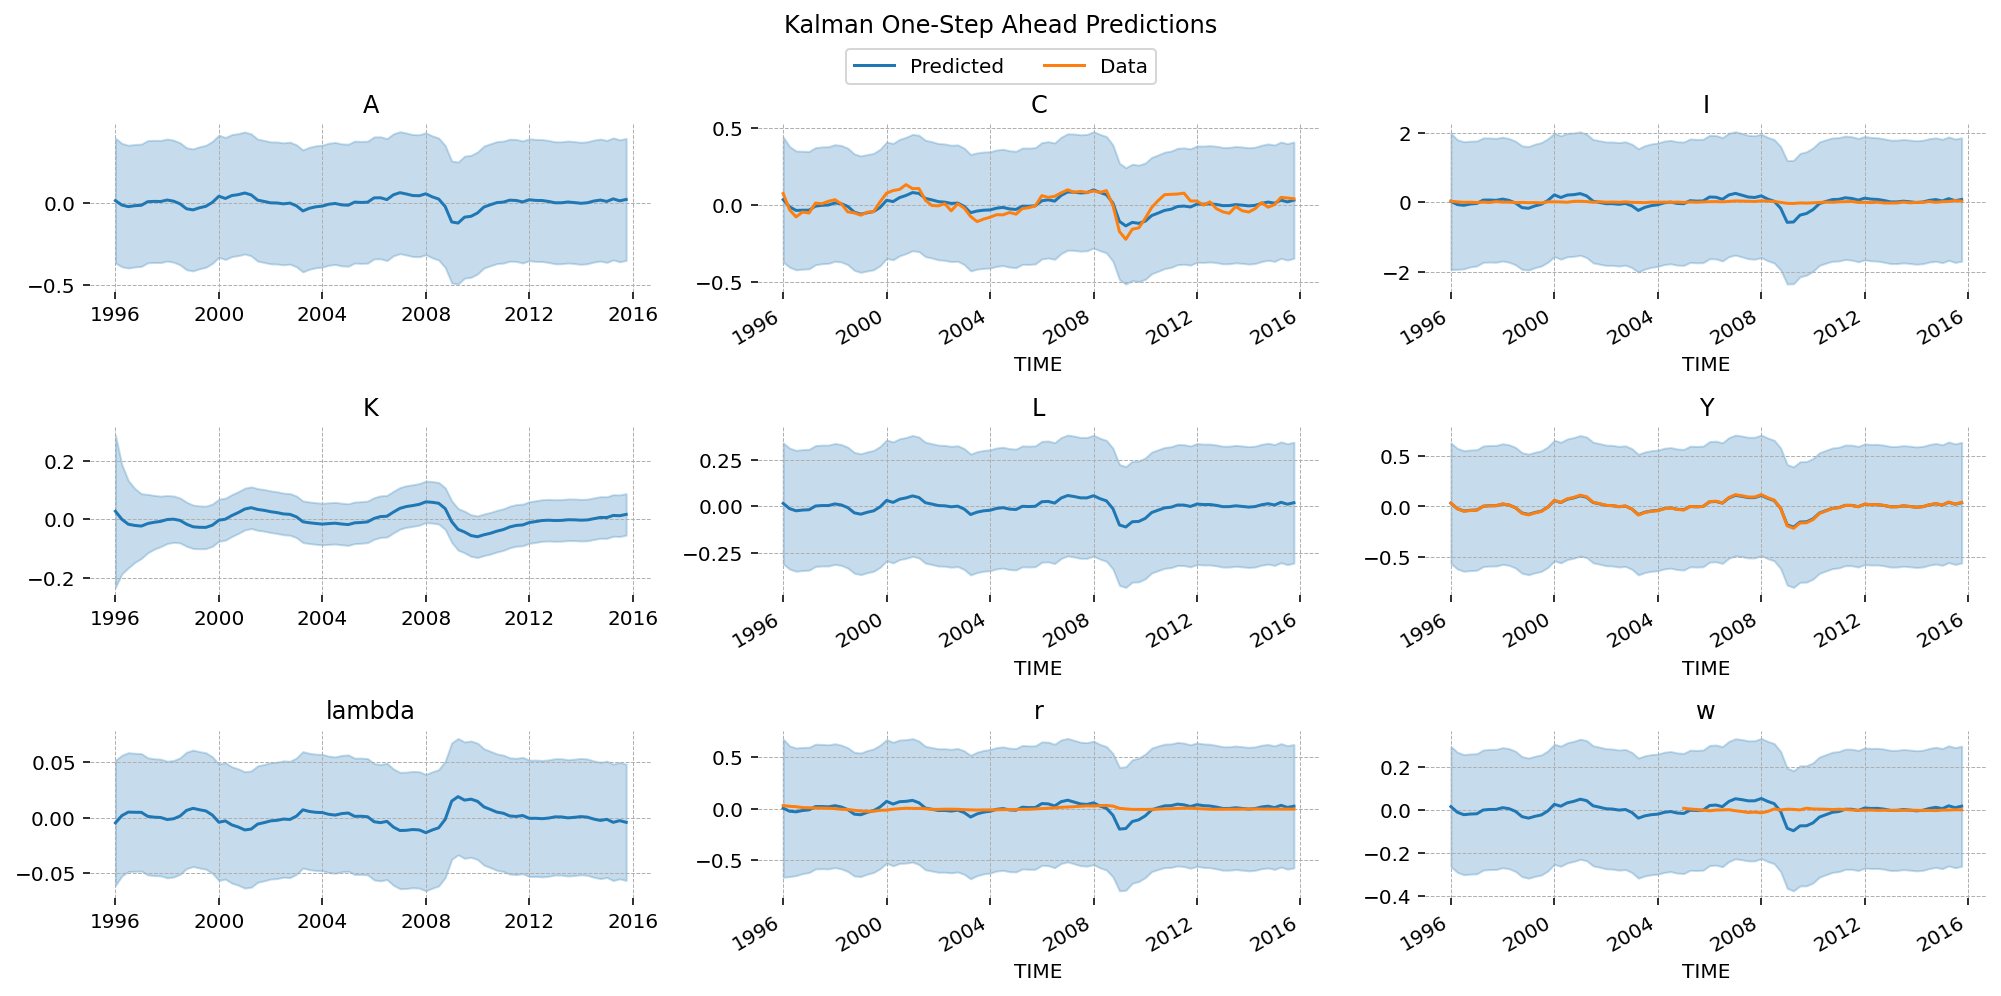

In [26]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

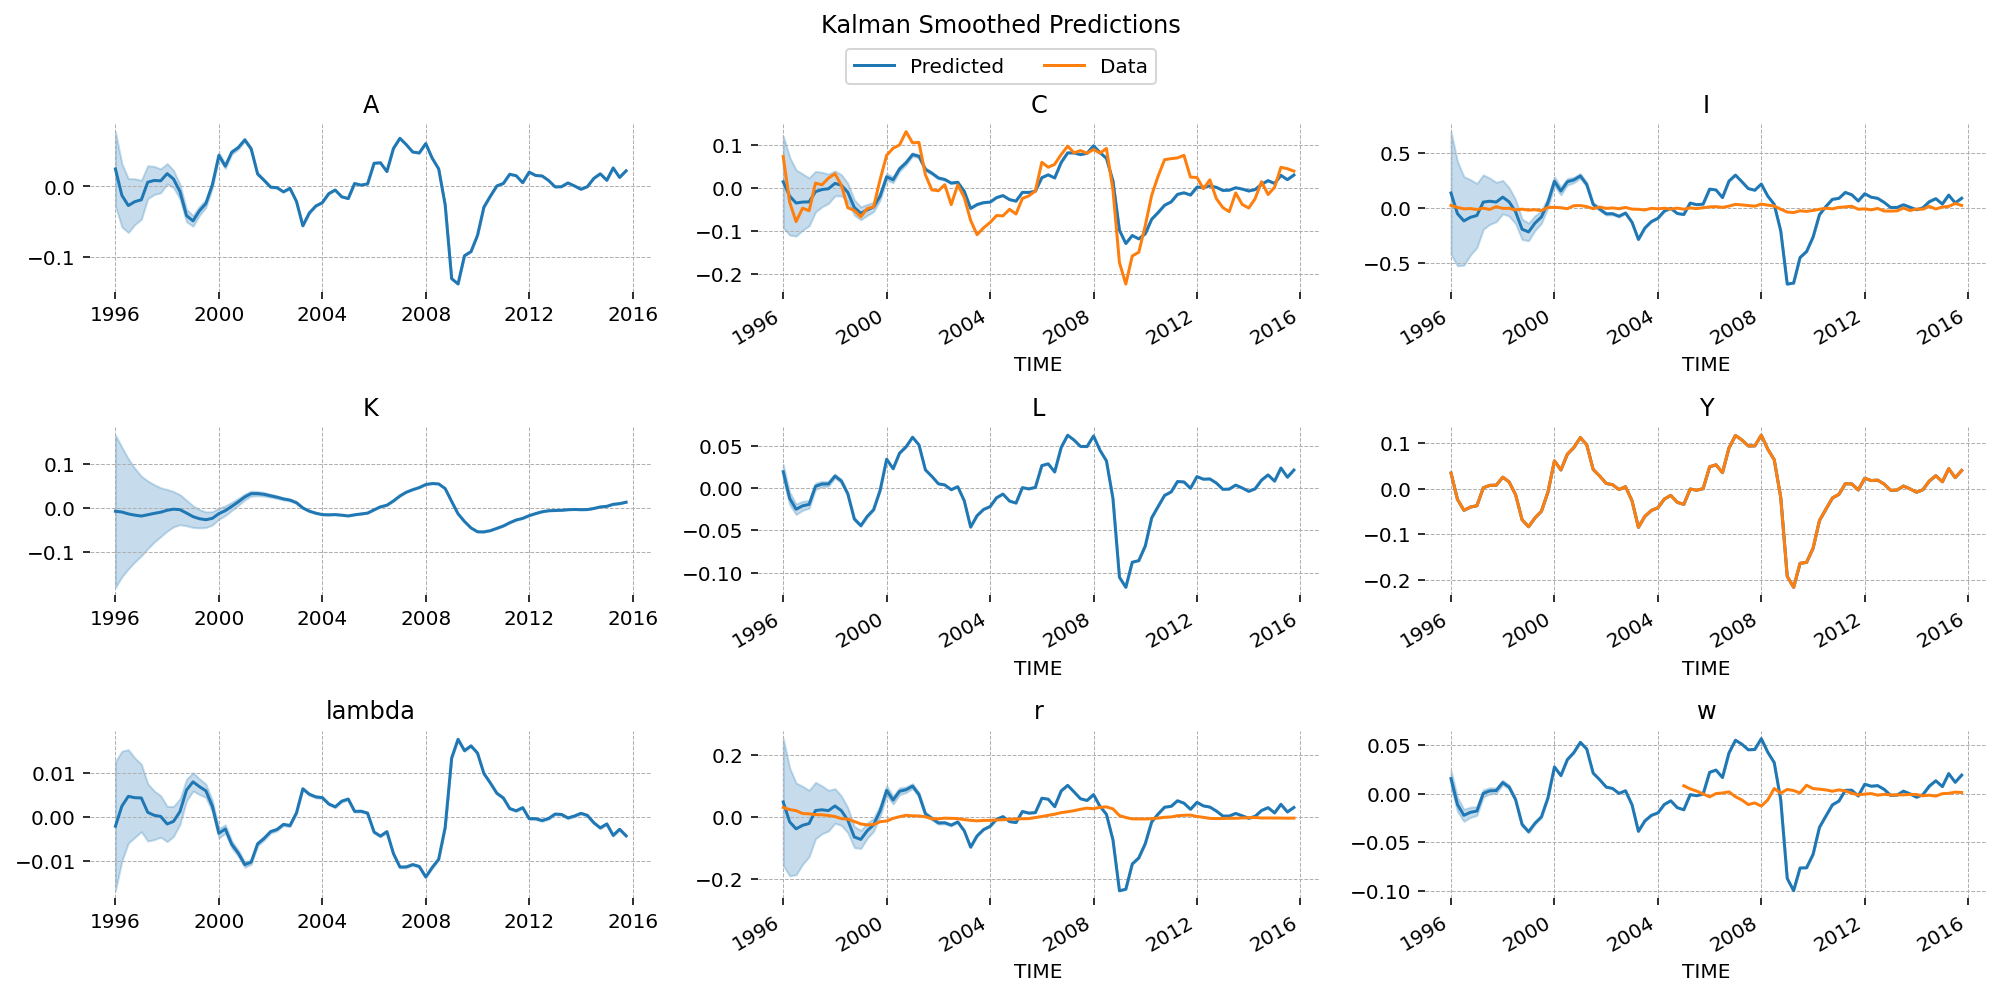

In [27]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_8"></a>

In [28]:
mle_forecast = mle_res.get_forecast(steps=test_size)

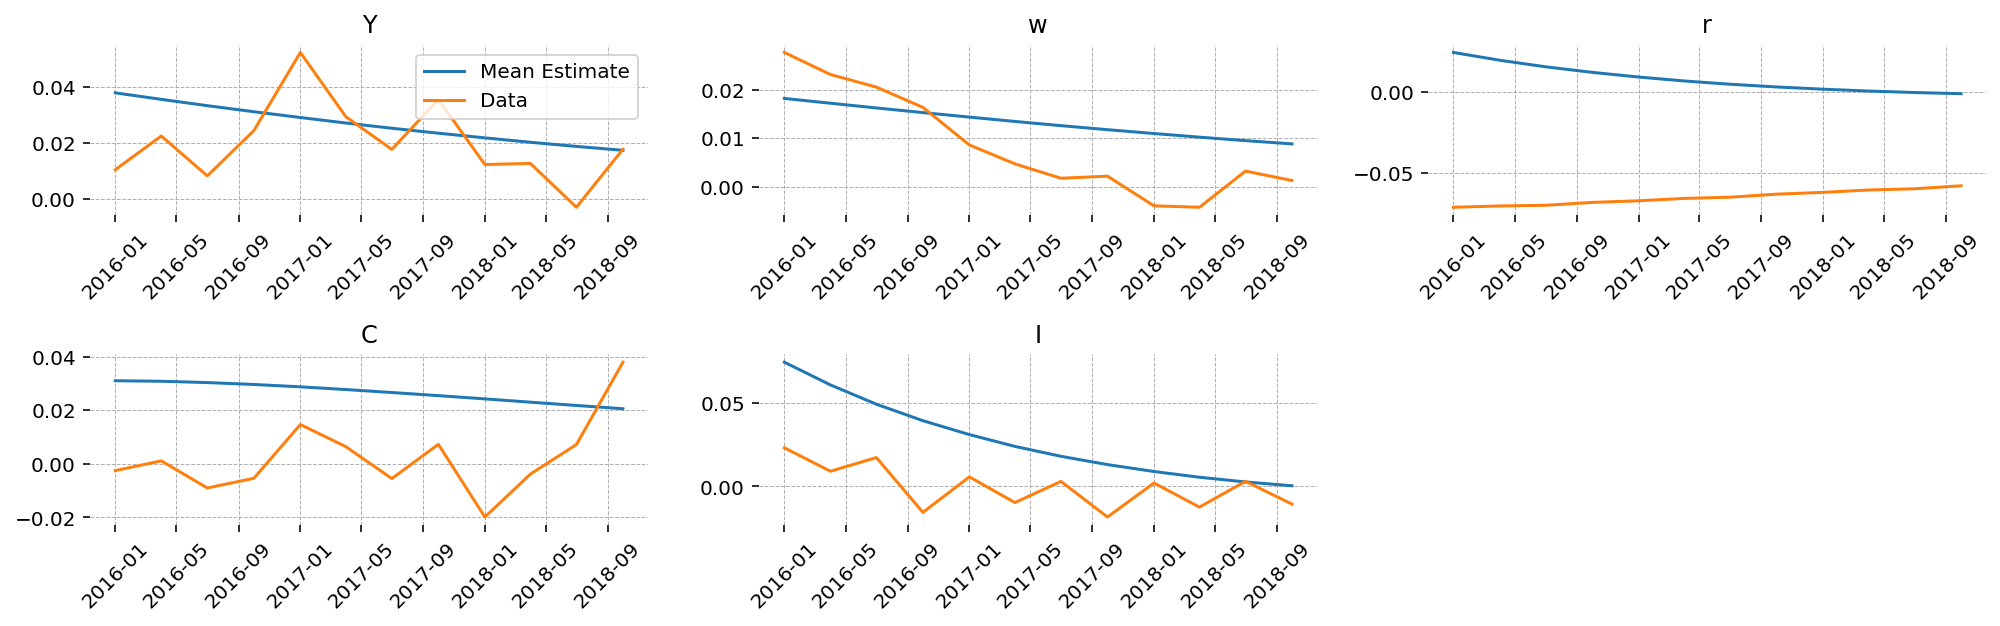

In [29]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

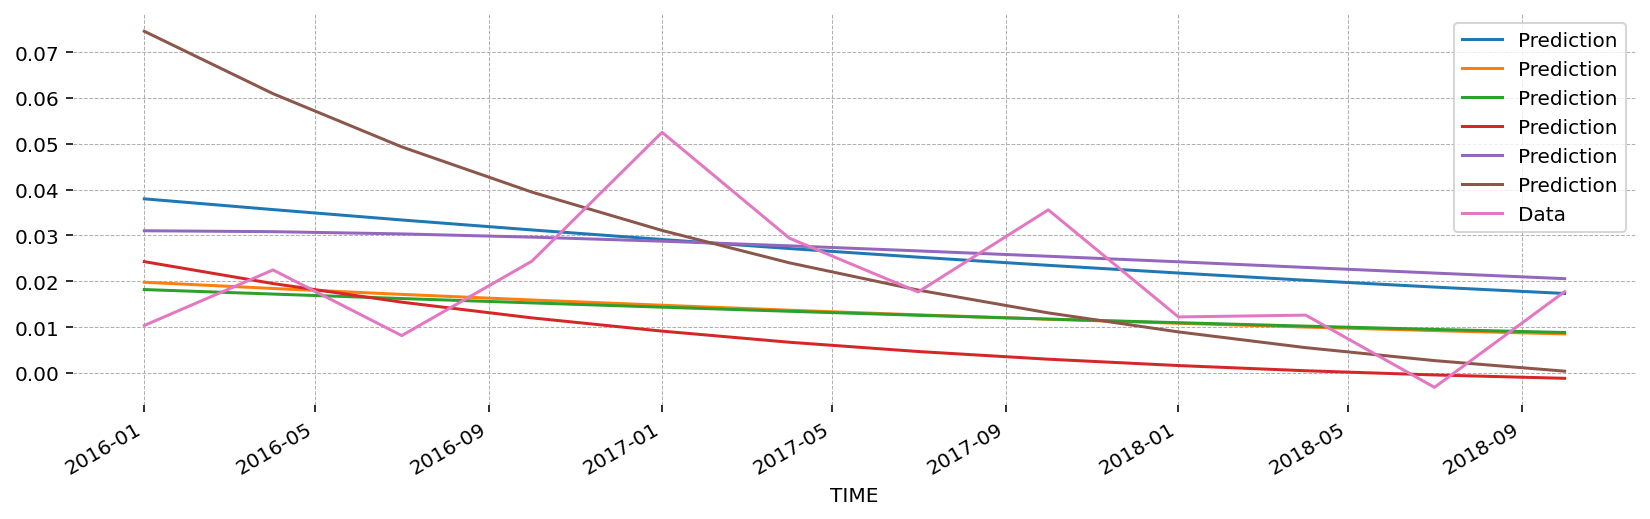

In [30]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Impulse response <a class="anchor" id="section_4_5"></a>

In [31]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

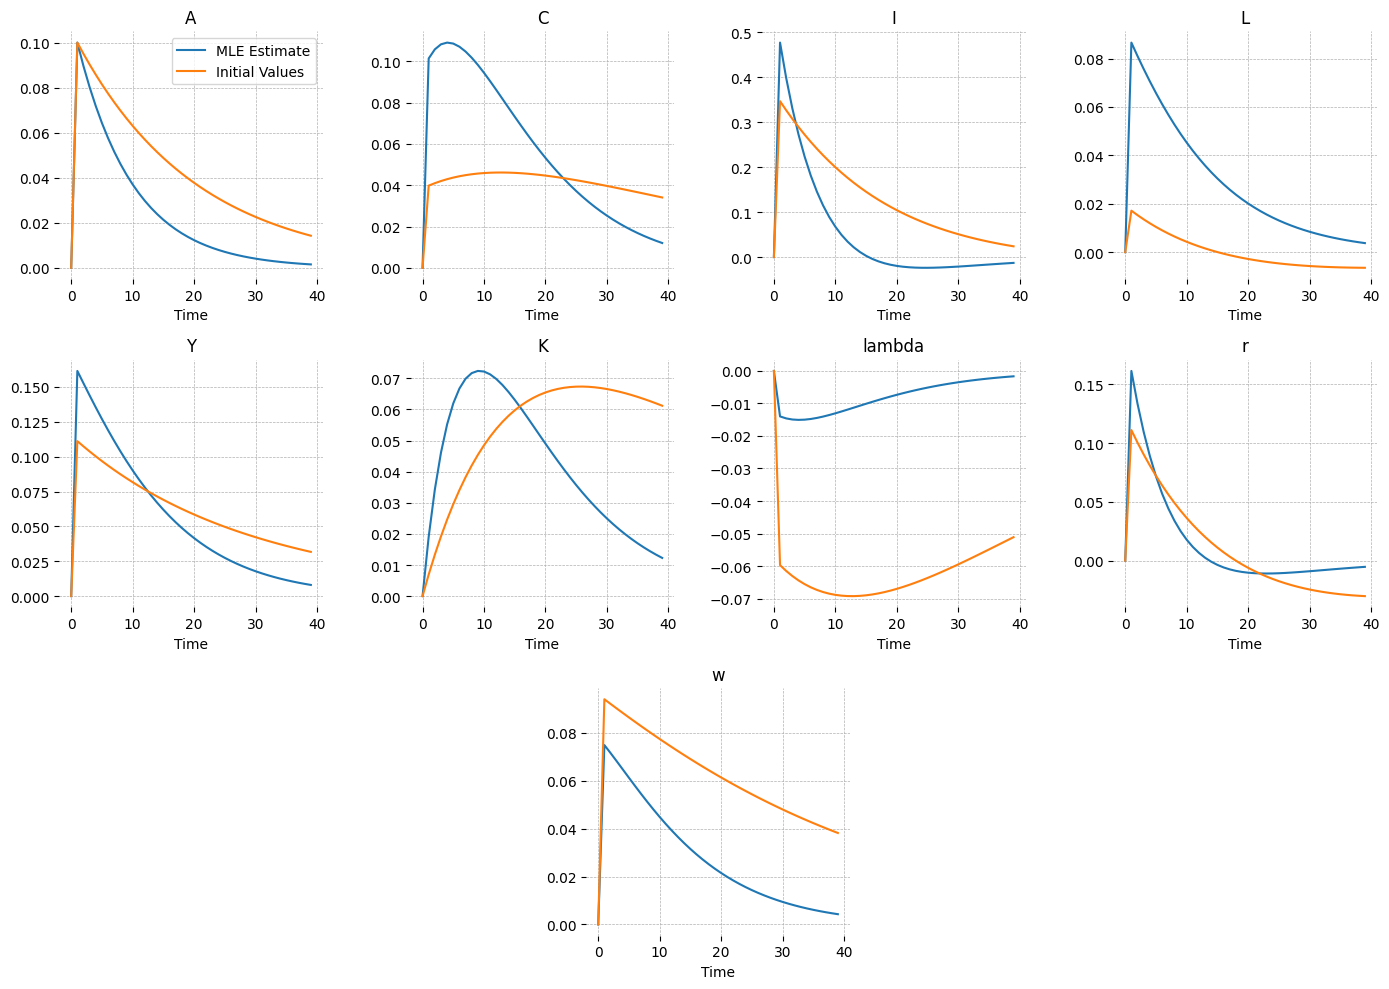

<Figure size 1400x1000 with 0 Axes>

In [32]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

# Bond Model

In [33]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_bonds.gnc'))

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		U_t
	The following "variables" were defined as constants and have been substituted away:
		B_t,mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_3_1"></a>

In [34]:
for equation in rbc.system_equations:
    display(equation)

-C_t + Div_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

beta*lambda_t+1 - lambda_t/r_G_t

-Div_t + TC_t + Y_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_3_2"></a>

In [35]:
rbc.steady_state()
rbc.solve_model(not_loglin_variable=['Div', 'TC'])

Steady state found! Sum of squared residuals is 1.830403819145629e-30
Solution found, sum of squared residuals:  1.1253491572151774e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [36]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
Div_ss             0.000
I_ss               0.715
K_ss              35.732
L_ss               0.820
TC_ss             -3.073
Y_ss               3.073
lambda_ss          0.276
r_G_ss             1.010
r_ss               0.030
w_ss               2.436


## Check Blanchard Kahn Conditions <a class="anchor" id="section_3_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [37]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,4.006795e-35,4.006795e-35,0.0
1,1.652291e-18,-1.652291e-18,-0.0
2,9.434787e-17,9.434787e-17,0.0
3,9.500000e-01,9.500000e-01,0.0
4,9.697454e-01,9.697454e-01,0.0
5,1.041615e+00,1.041615e+00,0.0
6,5.077961e+06,5.077961e+06,0.0


In [38]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [39]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,0.034739,0.025376,0.030090,0.073761,NaN,0.006896
1996-04-01,-0.023203,0.006568,0.023159,-0.032295,NaN,NaN
1996-07-01,-0.047401,-0.006060,0.019601,-0.077407,NaN,NaN
1996-10-01,-0.040238,-0.003936,0.010456,-0.046165,NaN,NaN
1997-01-01,-0.037205,-0.012070,0.009416,-0.052189,NaN,-0.005354


In [40]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [41]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':0.1,
                    'sigma_L':0.3,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.01,
                    'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=0.001, high=5.0),
                    'sigma_L':IntervalTransformer(low=0.001, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [42]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f 80.9597
basinhopping step 1: f 1.61693 trial_f 1.61693 accepted 1  lowest_f 1.61693
found new global minimum on step 1 with function value 1.61693
basinhopping step 2: f 1.3457 trial_f 1.3457 accepted 1  lowest_f 1.3457
found new global minimum on step 2 with function value 1.3457
basinhopping step 3: f 0.139629 trial_f 0.139629 accepted 1  lowest_f 0.139629
found new global minimum on step 3 with function value 0.139629
basinhopping step 4: f -0.665887 trial_f -0.665887 accepted 1  lowest_f -0.665887
found new global minimum on step 4 with function value -0.665887
basinhopping step 5: f -1.0367 trial_f -1.0367 accepted 1  lowest_f -1.0367
found new global minimum on step 5 with function value -1.0367
basinhopping step 6: f -3.27616 trial_f -3.27616 accepted 1  lowest_f -3.27616
found new global minimum on step 6 with function value -3.27616
basinhopping step 7: f -2.54378 trial_f -2.54378 accepted 1  lowest_f -3.27616
basinhopping step 8: f -2.54378 trial_f 0.88

In [43]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                   80
Model:                                  DSGEModel   Log Likelihood                  95.139
Date:                            Sat, 10 Dec 2022   AIC                           -166.277
Time:                                    11:14:29   BIC                           -137.693
Sample:                                01-01-1996   HQIC                          -154.817
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.7675     11.396      0.067      0.946     -21.568      23.103
sigma_C              0.0912     12.955      0.007      0.994     -25.300      25.482
sigma_L              0.8198     19.919      0.041      0.967     -38.220      39.859
alpha                0.2887     43.781      0.007      0.995     -85.521      86.099
beta                 0.9942      5.242      0.190      0.850      -9.280      11.269
delta                0.0302      0.454      0.067      0.947      -0.860       0.920
sigma2.epsilon_A     0.0583      5.275      0.011      0.991     -10.280      10.397
sigma2.L             0.0820      0.050      1.653      0.098      -0.015       0.179
sigma2.w             0.0856      0.046      1.852      0.064      -0.005       0.176
sigma2.r             0.0166      0.286      0.058      0.954      -0.543       0.576
sigma2.C             0.0324      0.212      0.153      0.878      -0.383       0.448
sigma2.I             0.7738     25.892      0.030      0.976     -49.974      51.522
=================================================================================================================================
Ljung-Box (L1) (Q):     14.20, 0.00, 65.06, 68.40, 58.36, 58.16   Jarque-Bera (JB):   360.35, 506.52, 58.26, 13.09, 16.26, 103.08
Prob(Q):                     0.00, 1.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                    0.00, 0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H):       0.47, 0.60, inf, 0.10, 1.81, 1.81   Skew:                      -2.09, 1.58, 1.01, 0.92, -0.70, 1.67
Prob(H) (two-sided):         0.06, 0.18, 0.00, 0.00, 0.13, 0.13   Kurtosis:                  12.52, 14.92, 6.66, 3.75, 4.72, 7.45
=================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_7"></a>

Predictions

This model shows interesting dynamics fro consumption. Even though time lagged, the predictions do somehow seem to follow the consumption pattern of the italian economy.

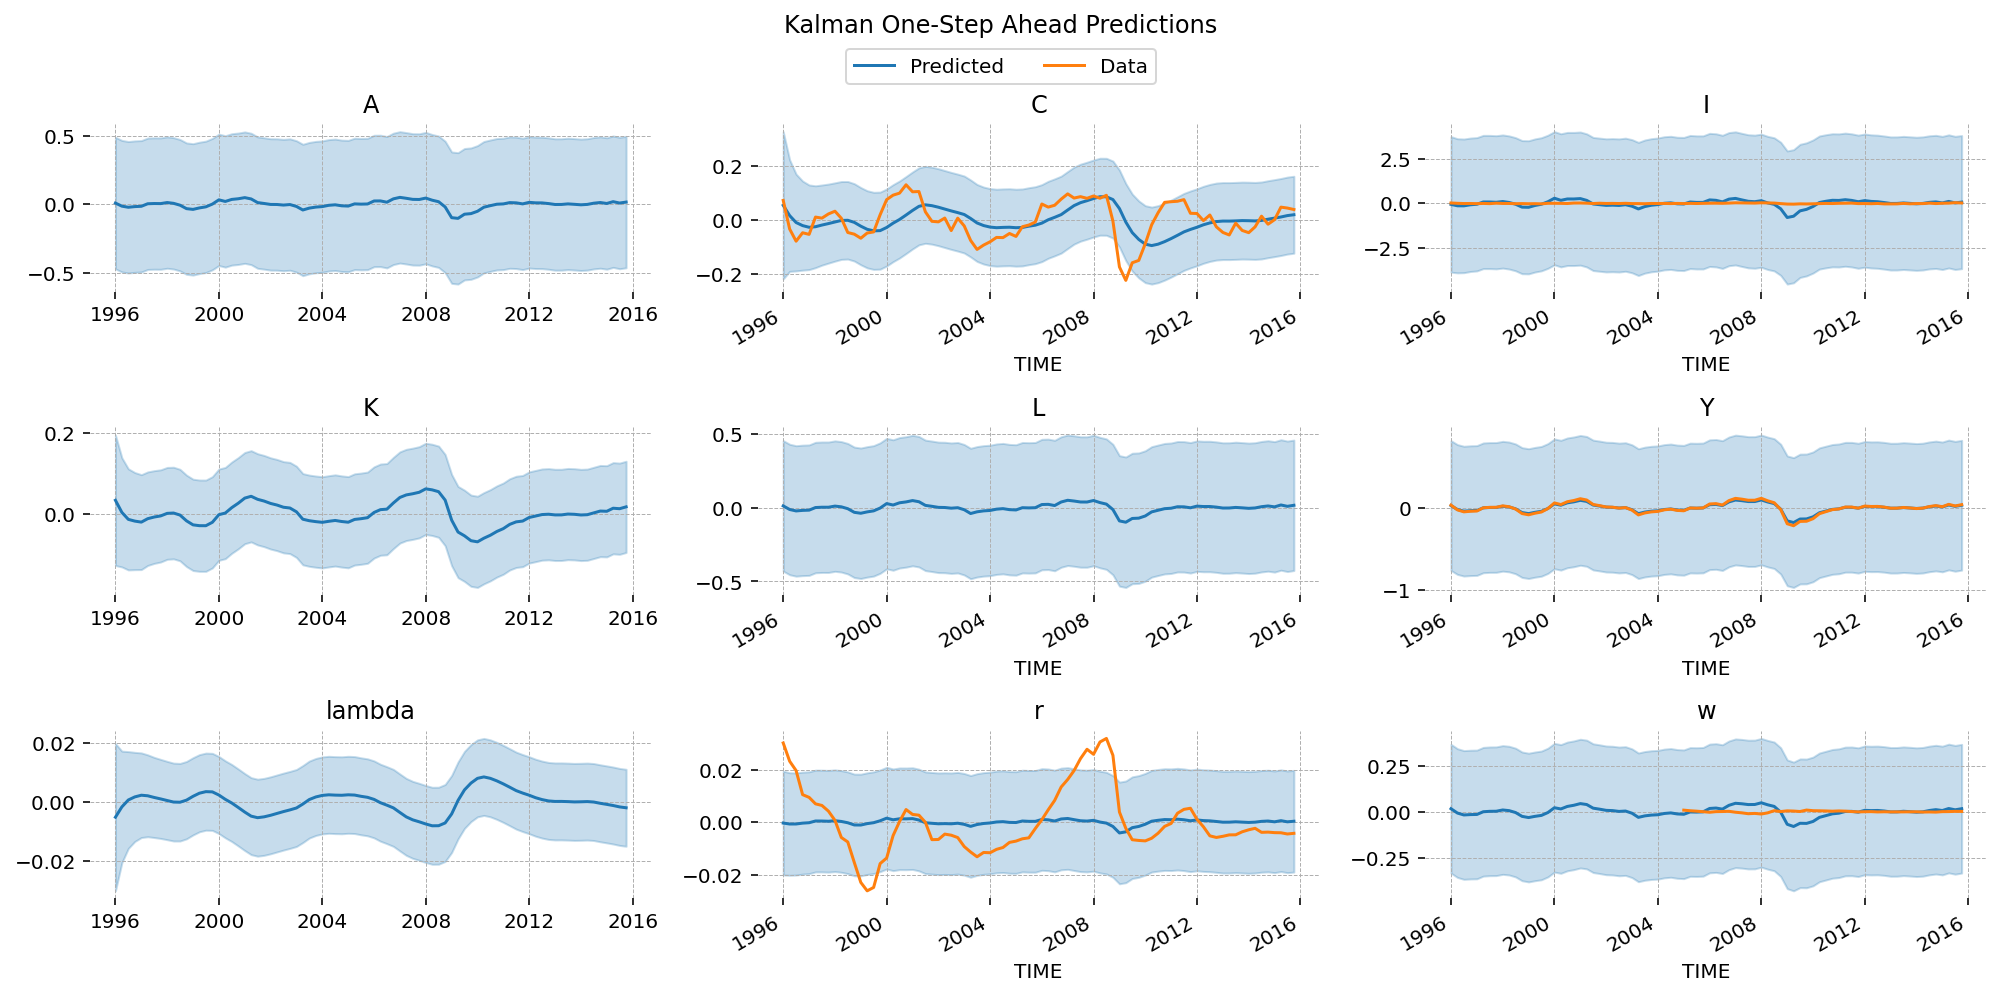

In [51]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

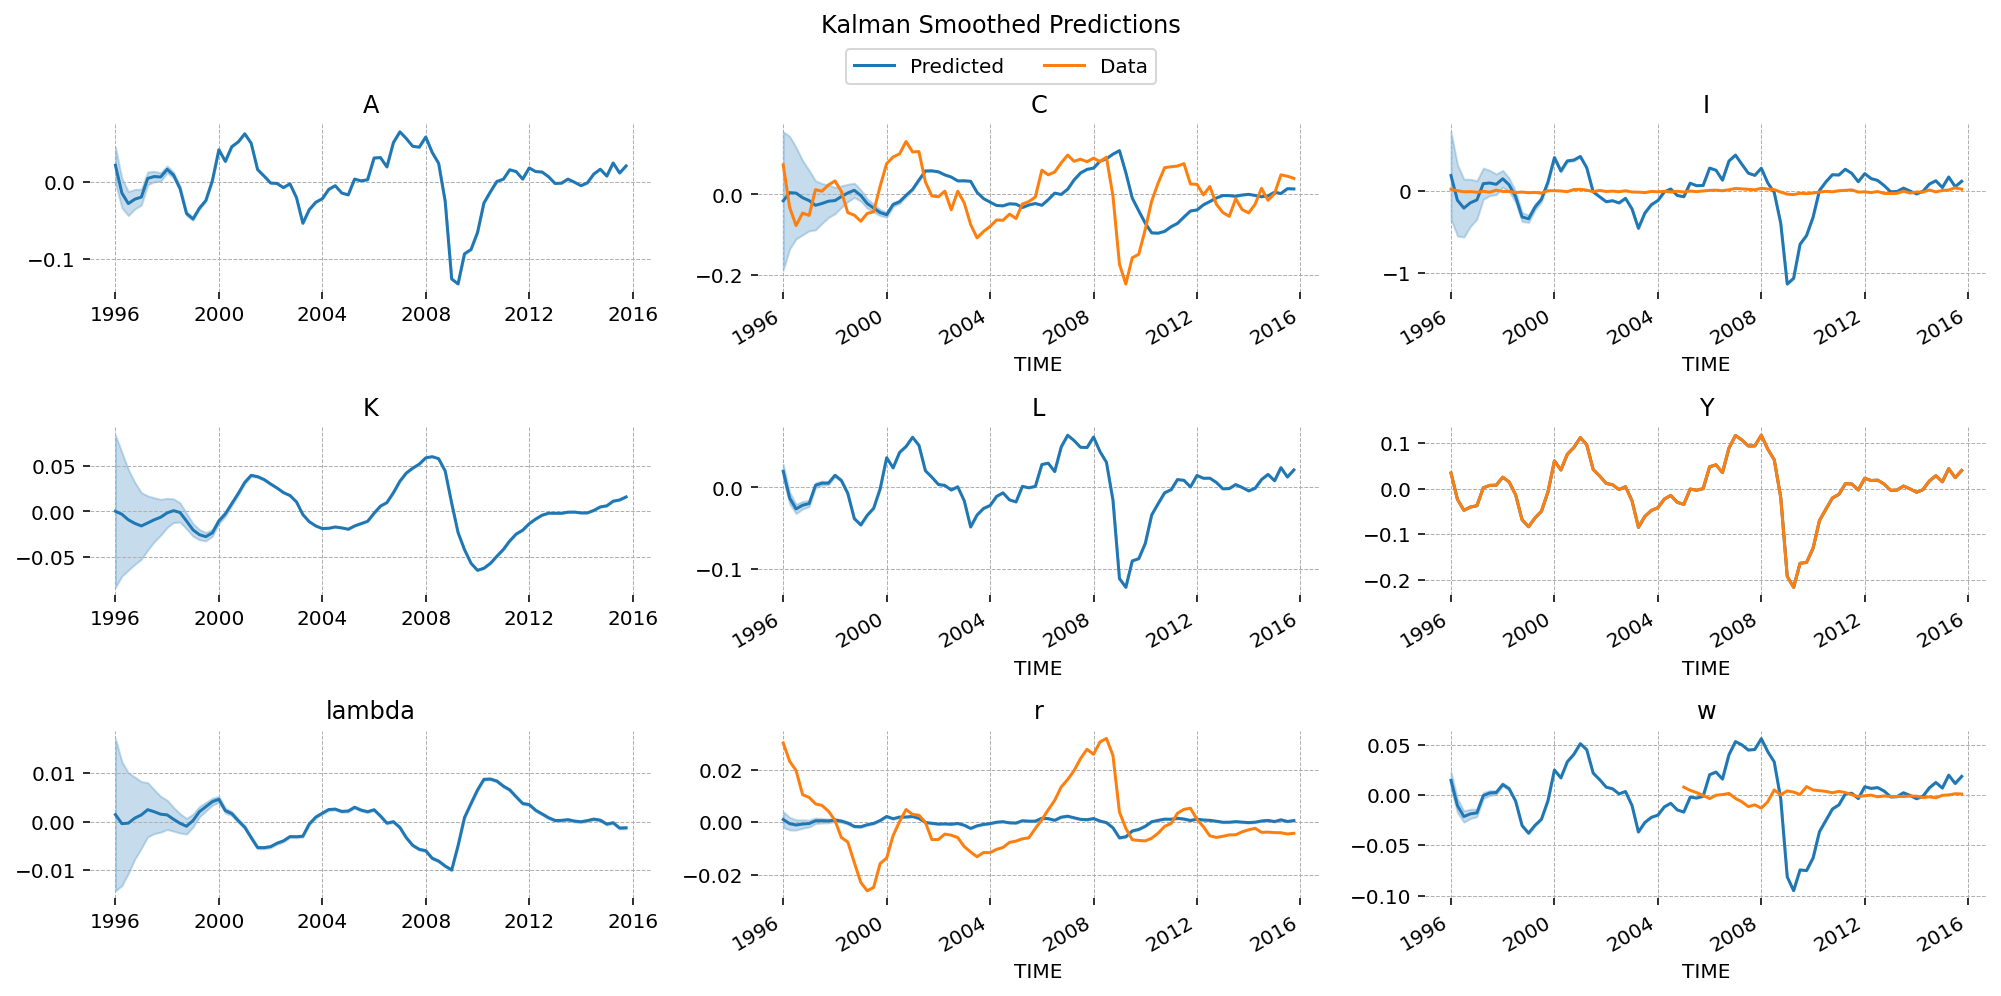

In [52]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_8"></a>

In [53]:
mle_forecast = mle_res.get_forecast(steps=test_size)

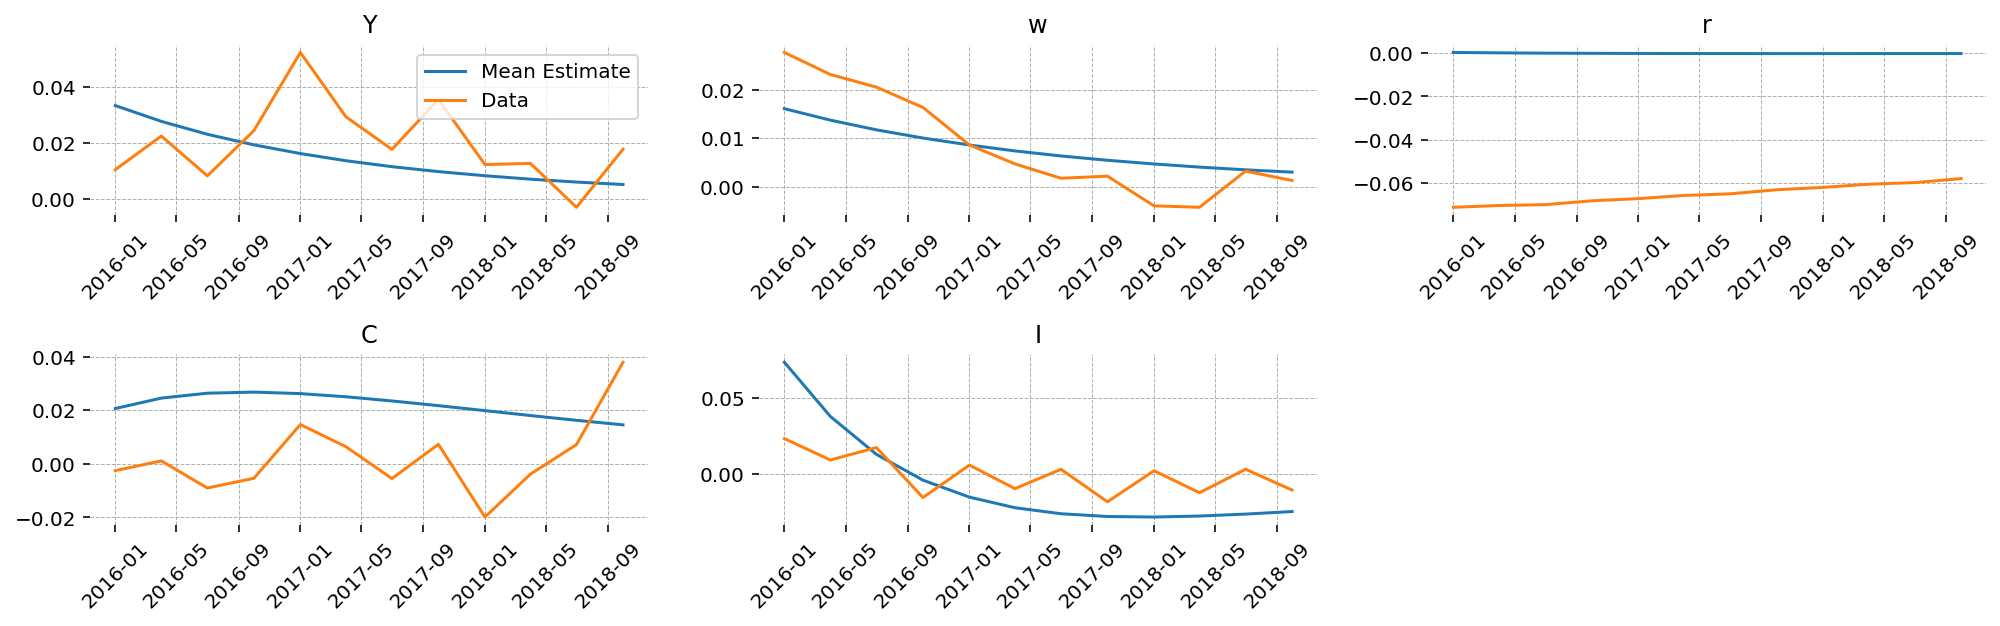

In [54]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

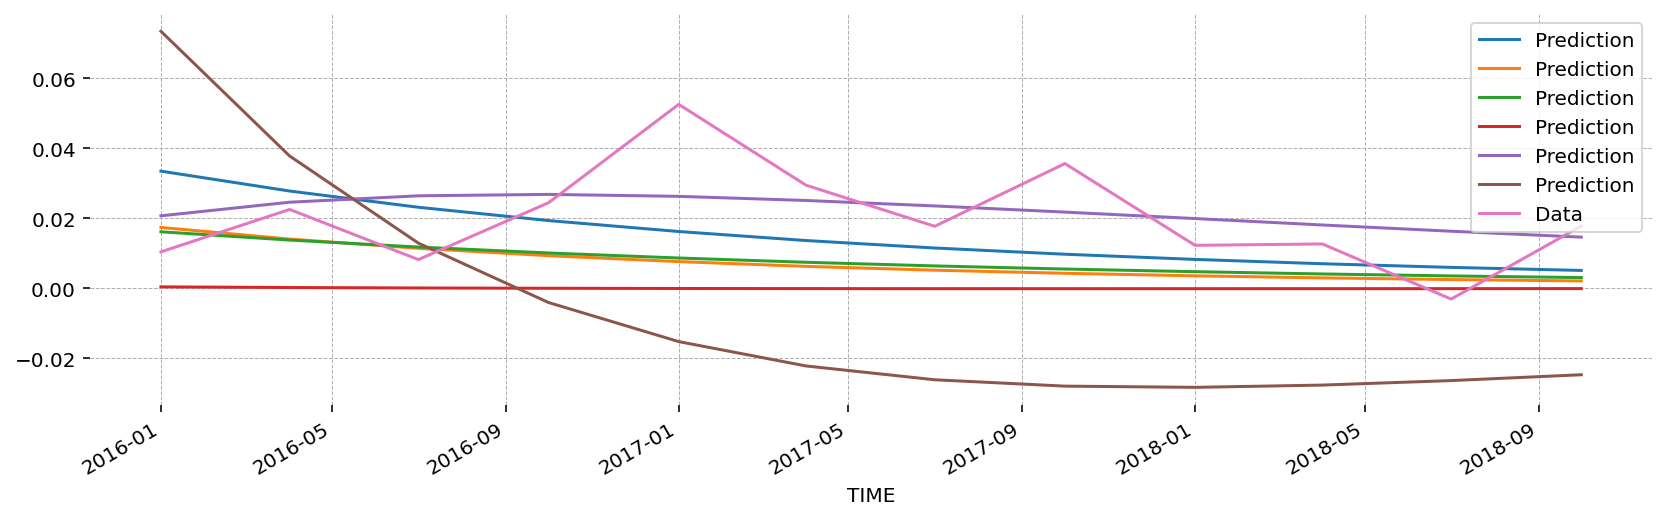

In [55]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Impulse response <a class="anchor" id="section_4_5"></a>

In [56]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

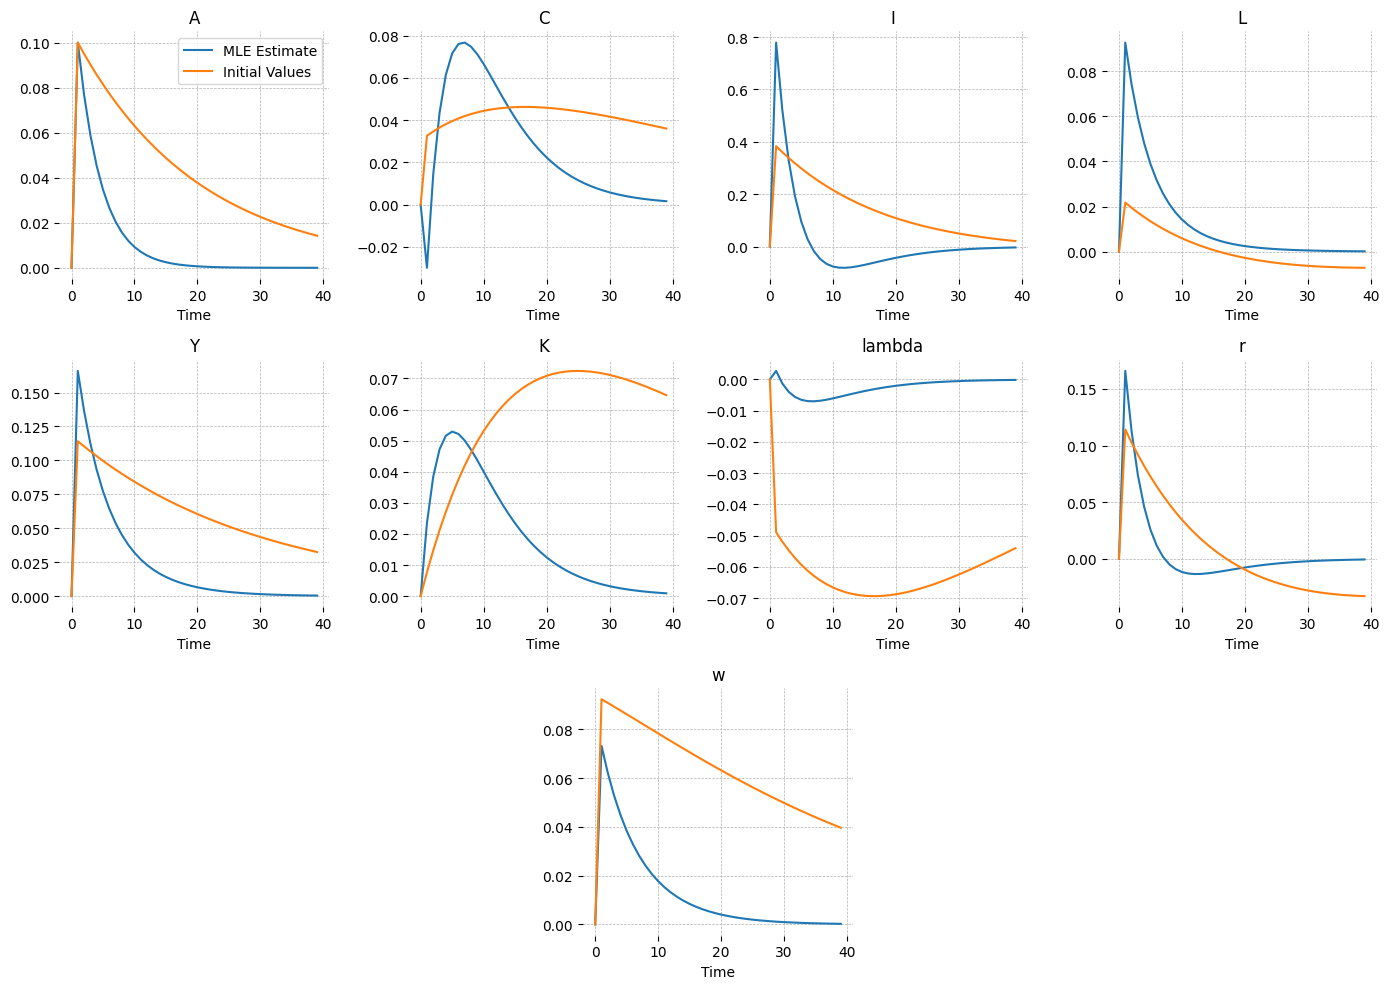

<Figure size 1400x1000 with 0 Axes>

In [57]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()